## II.금융 시계열의 특성

### 프로그래밍 환경 설정
 - 데이터 라이브러리 지정
 - 한글 관련 설정 등

In [3]:
!pip install pyxirr

In [4]:
## 사용자 정의 모듈 업데이트시마다 자동 load

%load_ext autoreload
%autoreload 2

### 공통 라이브러리 입수
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.font_manager as fm

from IPython.display import display

import os
import sys

# ### 시계열 예측 라이브러리
# from sklearn.metrics import mean_squared_error
# from pmdarima import auto_arima

### 금융 / 경제 데이터
import yfinance as yf
# from fredapi import Fred

### 금융 / 경제 함수
# import numpy_financial as npf
from pyxirr import xirr

### 통계함수
from scipy.stats import norm
from scipy.stats import jarque_bera
from scipy.optimize import minimize
# from scipy.optimize import newton
# from numpy.linalg import inv

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

### 인터넷 접속 라이브러리 (한국은행,통계청)
import requests

### 그래프 셋팅 (runtime configuration parameters (rcParams))
# plt.rcParams['font.family'] ='Malgun Gothic'  # 한글 깨짐 방지
# plt.rcParams['axes.unicode_minus'] = False    # 마이너스 부호 깨짐 방지
plt.style.use('ggplot')                       # 그래프 스타일

### 사용자 정의 모듈 import
import PM_Tool_Kit_2025 as pk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 들어가기 앞서....
1. 수익률의 정의
- Arithmetic Return, Geometric Return
- Time Weighted Return(TWR), Internal Rate of Return(IRR), Yield to Matirity(YTM), CAGR (Compounded Average Growth Rate)




In [5]:
### IRR과 CAGR 비교

# 예제 데이터 프레임

df_return = pd.DataFrame({'Date':['20201231','20210630','20211231','20220630','20221231'],
                          'Cash_Flow':[-1000,0,765,0,690],
                          'Fund_NAV_CF':[0,1100,1265,600,690],
                          'Fund_NAV':[1000,1100,500,600,0]})

df_return['Date'] = pd.to_datetime(df_return['Date'])
df_rtn = df_return['Fund_NAV_CF'] / df_return['Fund_NAV'].shift(1) - 1

print(df_return)

### IRR 계산

irr = xirr(df_return['Date'],df_return['Cash_Flow'])
print(f' IRR : {irr:.4%}')

### CAGR 계산

cagr = (1+df_rtn).prod()**(1/2)-1
print(f' CAGR : {cagr:.4%}')



        Date  Cash_Flow  Fund_NAV_CF  Fund_NAV
0 2020-12-31      -1000            0      1000
1 2021-06-30          0         1100      1100
2 2021-12-31        765         1265       500
3 2022-06-30          0          600       600
4 2022-12-31        690          690         0
 IRR : 29.6998%
 CAGR : 32.1249%


2.수정주가와 원주가, 주가 로그변환

[*********************100%***********************]  9 of 9 completed


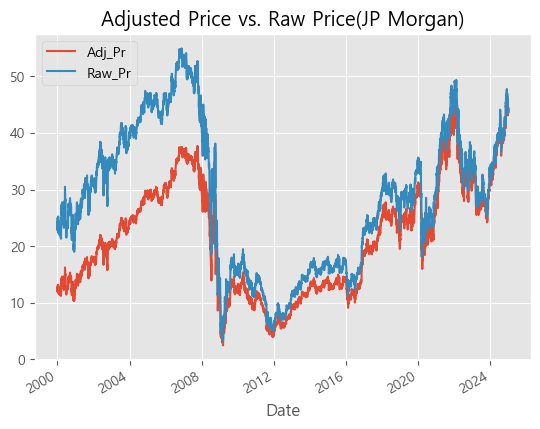

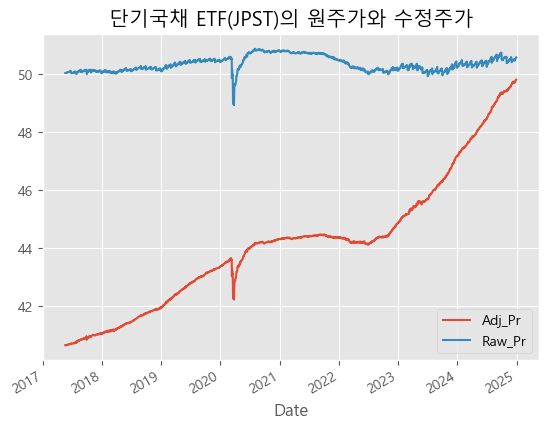

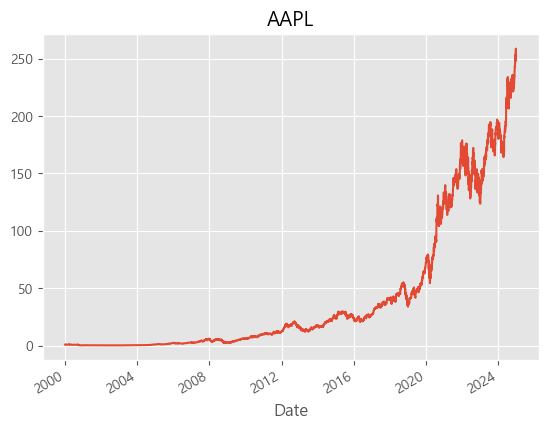

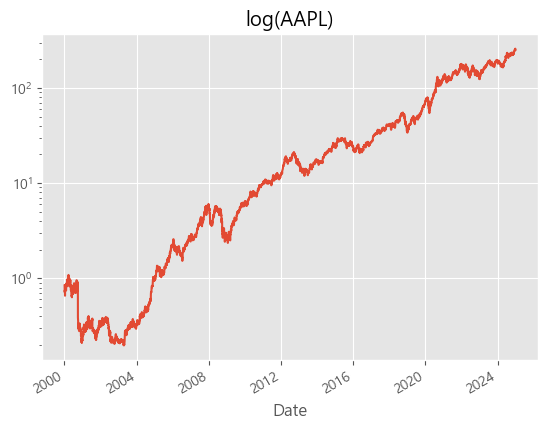

In [6]:
### 수정주가와 원주가 챠트로 비교 : 차이가 발생하는 이유?
### 원주가를 봐야 하는 경우 vs. 수정주가를 봐야 하는 경우

# 데이터 입수

stdt = '2000-01-01'
ltdt = '2024-12-31'

stk_data = yf.download(["AAPL",'MSFT','AGG','^GSPC','SPY','BAC','JPST','069500.KS','005930.KS'],
                       start=stdt,
                       end=ltdt,
                       auto_adjust = False)
stk_data.ffill(inplace = True)  # 결측치는 전일값으로 대체
stk_data = stk_data.tz_localize(None)

bac_adj = stk_data['Adj Close']['BAC']
bac_raw = stk_data['Close']['BAC']

bac_adj.plot(label = 'Adj_Pr')
bac_raw.plot(label = 'Raw_Pr')
plt.legend()
plt.title('Adjusted Price vs. Raw Price(JP Morgan)')
plt.show()

jpst_adj = stk_data['Adj Close']['JPST']
jpst_raw = stk_data['Close']['JPST']

jpst_adj.plot(label = 'Adj_Pr')
jpst_raw.plot(label = 'Raw_Pr')
plt.legend()
plt.title('단기국채 ETF(JPST)의 원주가와 수정주가')
plt.show()

### 주가 로그변환

apple_pr = stk_data.xs('AAPL',level = 'Ticker', axis = 1)['Adj Close']
apple_pr.head()
apple_pr.plot()
plt.title("AAPL")
plt.show()
apple_pr.plot(logy = True)
plt.title("log(AAPL)")
plt.show()

In [7]:
### 연습










### 시계열 Frequency 변환, 연률화

In [8]:
### 데이터 주기 변경 함수 (일별데이터 => 일별,주별,월별)

def get_return(p, freq='D'):

    """
    일별 가격 데이터를 받아서 일별,주별,월별 수익률을 산출
    인덱스는 날짜 형식일 것
    """
    p = p.sort_index()

    if freq == 'D':  # 일별 수익률
        r = p.pct_change().dropna(how='all')

    if freq == 'W':  # 주별 수익률 (금~금)
        p_week = p.resample('W-FRI').last()  # 일별 데이터를 기간데이터(주별)로 변환하여 마지막 수치만 추출
        r = p_week.pct_change().dropna(how='all')

    if freq == 'M':  # 월별 수익률
        p_month = p.resample('ME').last()  # 일별 데이터를 기간데이터(월별)로 변환하여 마지막 수치만 추출
        r = p_month.pct_change().dropna(how='all')

    return r

### 수익률 연율화

def annualize_return(r,periods_per_year):
    """
    r : 수익률 행렬 (not 가격)
    periods_per_year : 월별 = 12, 주별 = 52, 일별 = 365 or 250
    """
    ### 결과 저장용 빈 데이터프레임
    df = pd.DataFrame(columns = r.columns, index = ['Annual_Rtn'],dtype = 'float')

    ### 각 컬럼별로 연율화 수익률 산출
    for i in r.columns:

      n_period =r[i].dropna().shape[0]
      compounded_return = (1+r[i]).prod()
      df.loc['Annual_Rtn',i] = compounded_return**(periods_per_year / n_period) - 1

    return df


### 표준편차 연율화

def annualize_vol(r,periods_per_year):
    """
    r : 수익률 행렬 (not 가격)
    periods_per_year : 월별 = 12, 주별 = 52, 일별 = 365 or 250
    """
    df = pd.DataFrame(columns = r.columns, index = ['Annual_Std'],dtype = 'float')

    for i in r.columns:
      df.loc['Annual_Std',i] = r[i].std()*(periods_per_year**0.5)

    return df


In [9]:
adj_pr = stk_data['Adj Close']

### 가격 => 수익률 변환 사용자 정의 함수
### 일별 = D, 주별 = W, 월별 = M

rtn_d = get_return(adj_pr,freq='D')
rtn_w = get_return(adj_pr,freq='W')
rtn_m = get_return(adj_pr,freq='M')

### 누적수익률

cum_return = (1+rtn_w).prod()-1

### 수익률과 표준편차의 연율화

ann_return = annualize_return(rtn_w,periods_per_year = 52)
ann_stdev = annualize_vol(rtn_w,periods_per_year = 52)


In [10]:
#### 연습

display(ann_return)







Ticker,005930.KS,069500.KS,AAPL,AGG,BAC,JPST,MSFT,SPY,^GSPC
Annual_Rtn,0.109069,0.046326,0.261163,0.029795,0.050452,0.026921,0.105578,0.076376,0.057857


### 금융 시계열 수익률과 정규분포 비교

In [11]:
### 금융시계열의 분포를 그리고, 정규분포와 비교하는 함수 작성

def check_normal(rtn,show_dist= True):

  """
  수익률 분포의 정규성 확인
  """

  # 결과 저장할 빈 데이터셋 정의
  rtn_desc = pd.DataFrame(columns = rtn.columns, index = ['Mean','Standard Deviation','Skewness','Kurtosis','JB_Stat','JB_P-Val'])

  # 정규성 검정 관련 통계량
  for i in rtn.columns:
    rtn_desc.loc['Mean',i] = rtn[i].mean()  # 평균
    rtn_desc.loc['Standard Deviation',i] = rtn[i].std() # 표준편차
    rtn_desc.loc['Skewness',i] = rtn[i].skew()  # 왜도
    rtn_desc.loc['Kurtosis',i] = rtn[i].kurtosis()  # 첨도
    jb_test = jarque_bera(rtn[i]) # Jarque-bera test statistics(정규성 검정)
    rtn_desc.loc['JB_Stat',i] = jb_test[0]
    rtn_desc.loc['JB_P-Val',i] = jb_test[1]

  # 그래프
  if show_dist:

    for i in rtn.columns:

      z = 4

      rtn_mean = rtn[i].mean()
      rtn_std = rtn[i].std()

      lower_limit = rtn_mean - z * rtn_std
      upper_limit = rtn_mean + z * rtn_std

      x_range = np.linspace(lower_limit, upper_limit, 100)
      fig, ax = plt.subplots(figsize=(15, 5))

      # density = True : 히스토그램의 면적이 1이 되도록 함
      plt.hist(rtn[i], density=True, bins=100, label=i, color='blue')
      plt.plot(x_range, norm.pdf(x_range, loc=rtn_mean, scale=rtn_std), label='Normal Dist.', color='orange',
                linewidth=3)

      for j in range(-3, 4):
          plt.axvline(rtn_mean + j * rtn_std, 0, 25, color='lightgray', linestyle='--', linewidth=2)

      plt.title(i)
      plt.xlabel('return', fontsize=12)
      plt.legend()
      plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

      plt.show()

  return rtn_desc


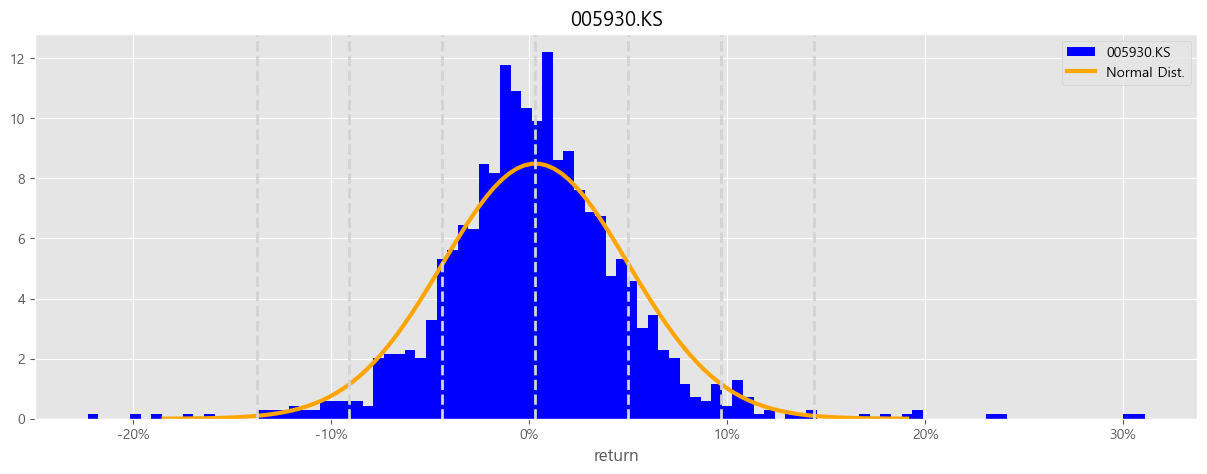

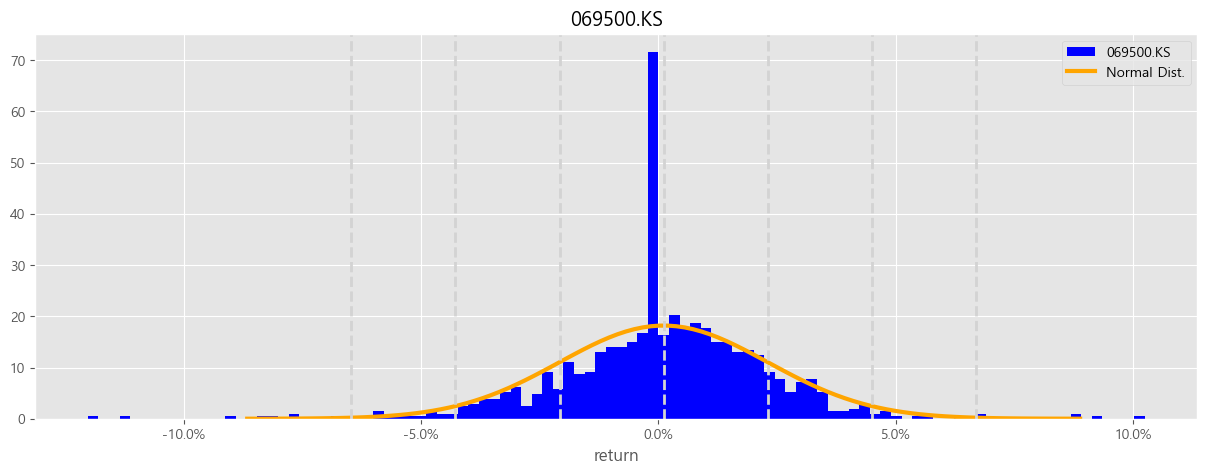

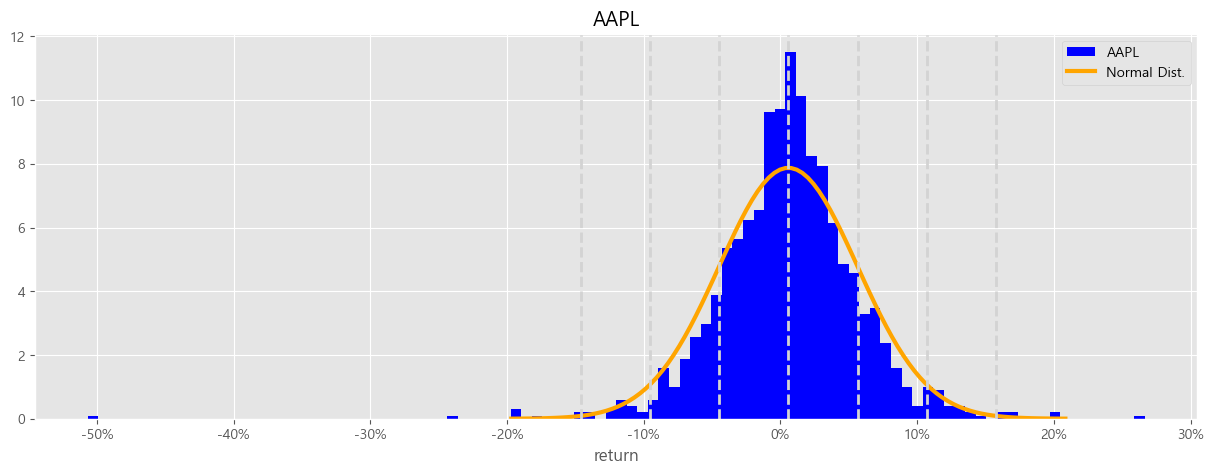

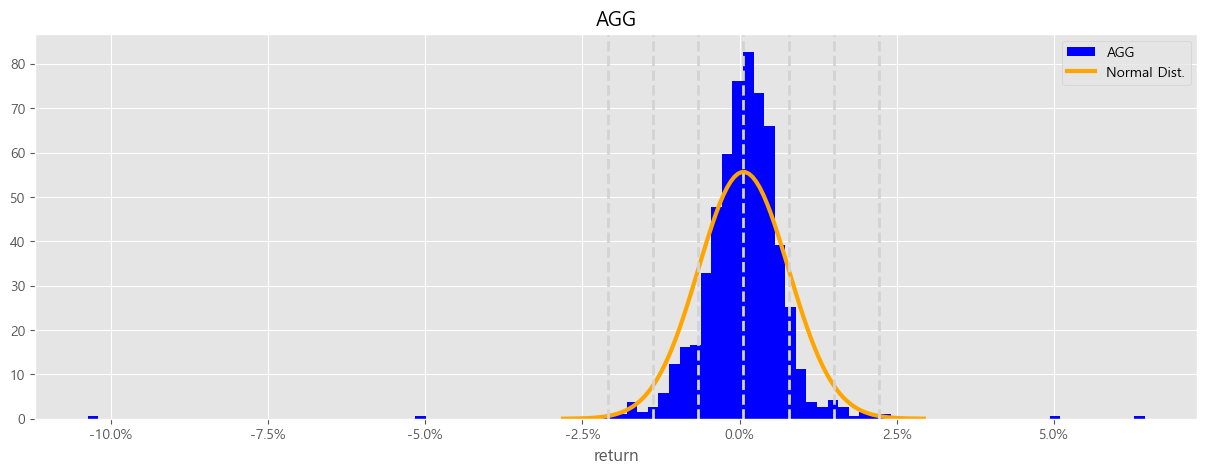

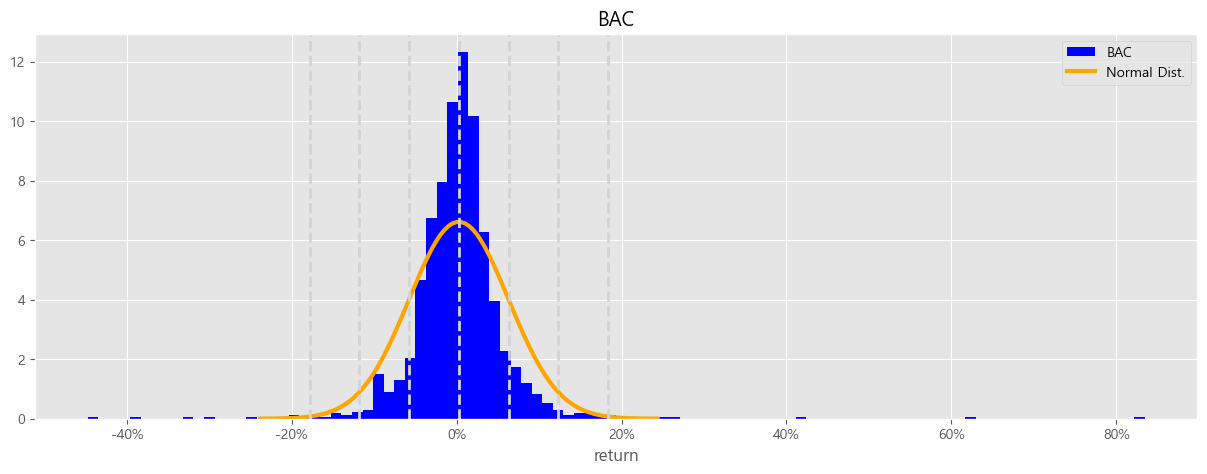

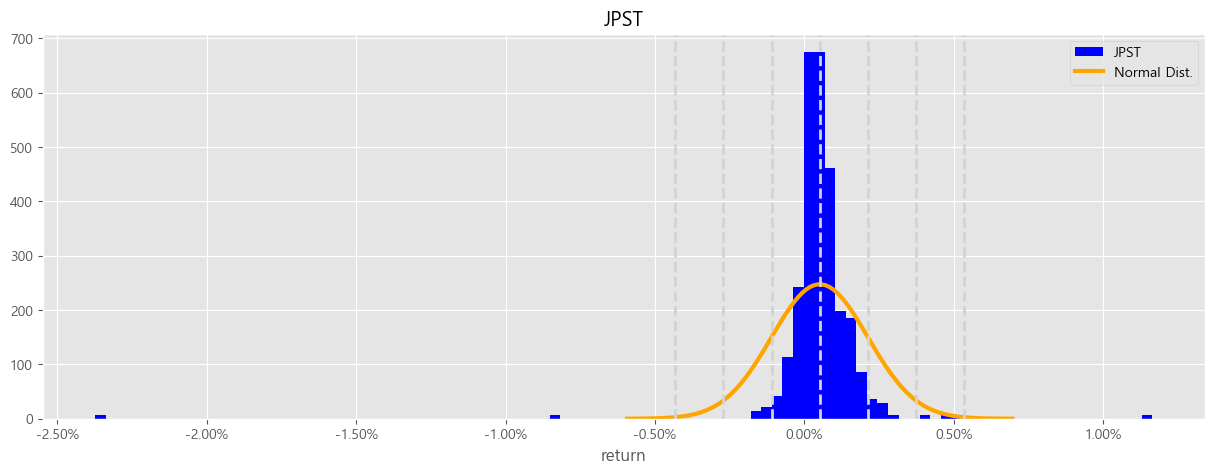

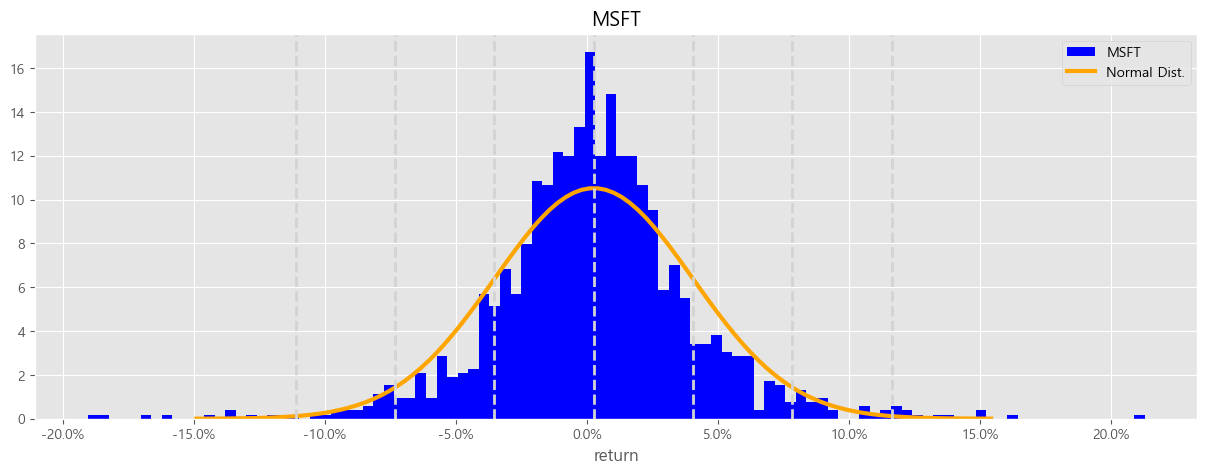

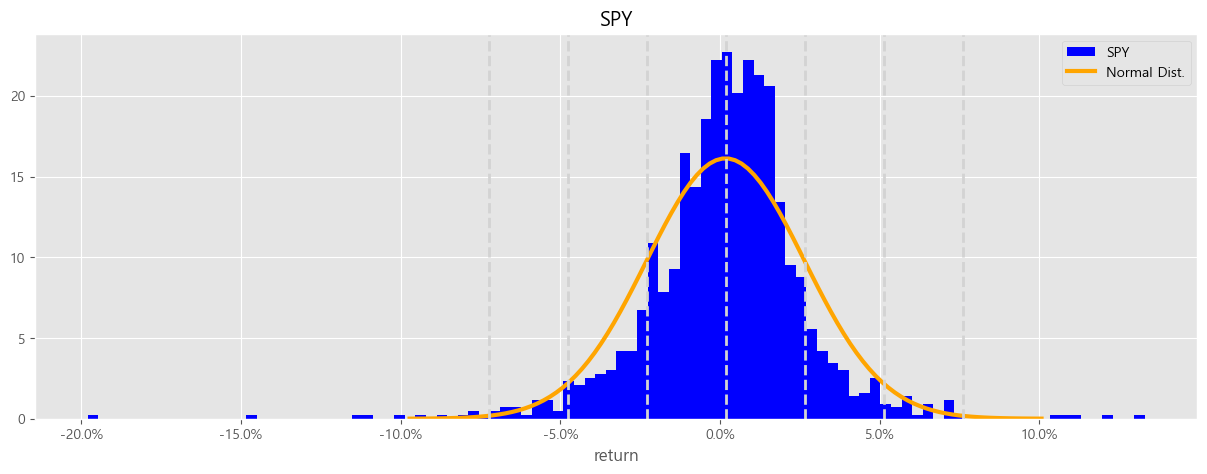

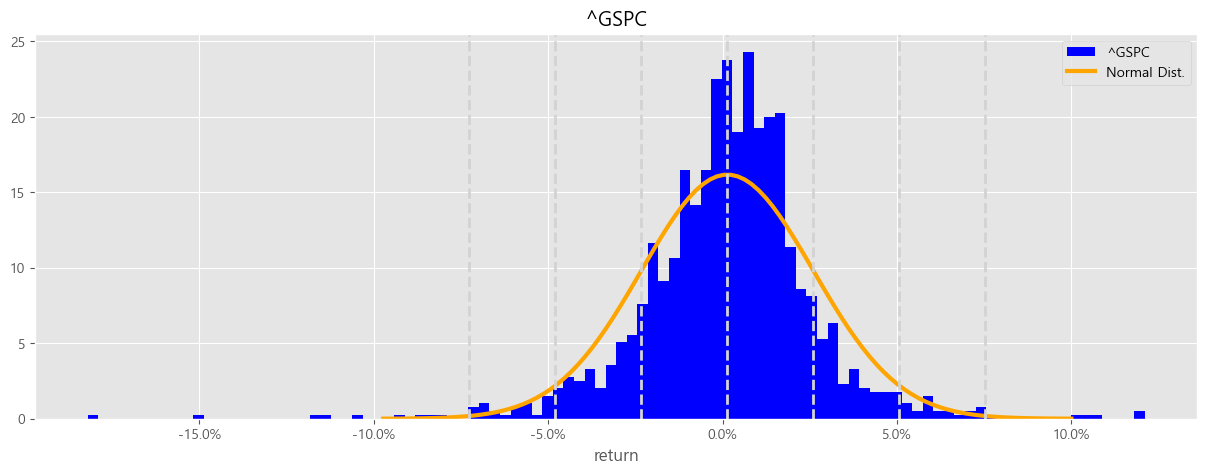

In [12]:
### 함수 실행
rtn_desc = check_normal(rtn_w,show_dist=True)

### Risk Metric > Value at Risk (VaR)
- Normal Disribution 가정
- Conrish-Fisher 변환 : 왜도와 첨도를 반영하여 분포를 조정
- Historical

In [13]:
### Value at Risk 산출 함수

def value_at_risk(rtn, level):

  """
  method = normal : Normal 분포 적용
  method = cf     : Conrish - Fisher expansion 적용
  method = hist   : Historical 분포 적용
  """

  df_VaR = pd.DataFrame(columns = rtn.columns,index = ['Normal VaR','C-F VaR','Historical VaR'])

  for i in rtn.columns:

    r = rtn[i].dropna()

    # Normal VaR
    z = norm.ppf(level/100) # Percent Point Function (norm.ppf(0.975) → 약 1.96)
    var_pct_normal = r.mean() + z * r.std()

    # Historical VaR
    var_pct_hist = np.percentile(r, level)

    # modify the Z score based on observed skewness and kurtosis
    s = r.skew()
    k = r.kurt()
    z_cf = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )

    var_pct_cf = r.mean() + z_cf * r.std()

    df_VaR.loc['Normal VaR',i] = var_pct_normal
    df_VaR.loc['C-F VaR',i] = var_pct_cf
    df_VaR.loc['Historical VaR',i] = var_pct_hist

  return df_VaR

In [14]:
df_VaR = value_at_risk(rtn_w,level=5)
print(df_VaR)

Ticker         005930.KS 069500.KS      AAPL       AGG       BAC      JPST  \
Normal VaR     -0.074167 -0.034952 -0.077523 -0.011203 -0.096464 -0.002139   
C-F VaR        -0.065026 -0.037085 -0.082089 -0.008331  0.002467  0.000478   
Historical VaR -0.068172 -0.033984 -0.070598  -0.00948 -0.074869 -0.000561   

Ticker              MSFT       SPY     ^GSPC  
Normal VaR     -0.059679 -0.038955 -0.039173  
C-F VaR        -0.059588 -0.041139 -0.041532  
Historical VaR -0.055691 -0.038224 -0.038977  


### Risk Metric > MDD (Max Draw Down)
 - MDD : 전고점 대비 하락률. 실제 체감하는 손실과 유사

In [15]:
### MDD 산출 함수

def drawdown(p, show_mdd = False):

  """
  p의 전고점 대비 하락률
  """

  p = pd.DataFrame(p)   # p가 시리즈인 경우 데이터프레임으로 변환
  p_prev_max = pd.DataFrame(columns = p.columns)
  p_drawdown = pd.DataFrame(columns = p.columns)
  p_mdd = pd.DataFrame(columns = p.columns, index = ['MDD'])

  for i in p.columns:
    p_prev_max[i] = p[i].cummax()  # 전고점 값
    p_drawdown[i] = (p[i]-p_prev_max[i])/p_prev_max[i]  # 전고점 대비 현재가
    p_mdd.loc['MDD',i] = p_drawdown[i].min()

  if show_mdd == True:

    for i in p.columns:
      fig,ax = plt.subplots(1,2,figsize = (15,5))

      ax[0].plot(p[i],label = i)
      ax[0].plot(p_prev_max[i],label = 'prev_max')
      ax[1].plot(p_drawdown[i],label = 'Drawdown')
      ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))

      ax[0].legend()
      ax[1].legend()
      plt.suptitle(i)
      plt.show()

  return p_drawdown,p_mdd


In [16]:
p_dd,p_mdd = drawdown(adj_pr,show_mdd = False)
display(p_mdd)

Ticker,005930.KS,069500.KS,AAPL,AGG,BAC,JPST,MSFT,SPY,^GSPC
MDD,-0.648196,-0.380813,-0.818014,-0.184329,-0.934457,-0.032813,-0.687132,-0.551894,-0.567754


### 금융시계열의 특성 > All-in-one Function

In [17]:
def fs_desc(p, freq, rf = 0.03):

  """
    연간수익률, 변동성, VaR, MDD, Sharpe 등 주요 통계량을 하나로 보여줌
  """

  r = get_return(p,freq = freq)

  if freq == 'W':
    periods_per_year = 52

  if freq == 'M':
    periods_per_year = 12

  if freq == 'D':
    periods_per_year = 252


  r_rtn = annualize_return(r,periods_per_year)
  r_vol = annualize_vol(r,periods_per_year)
  r_var = value_at_risk(r,level=5)
  r_dd,r_mdd = drawdown(p,show_mdd = False)

  r_sharpe = pd.DataFrame(columns = r.columns, index = ['Sharpe'])
  r_sharpe.loc['Sharpe',:] = (r_rtn.loc['Annual_Rtn',:]-rf)/r_vol.loc['Annual_Std',:]
  r_all = pd.concat([r_rtn,r_vol,r_var,r_mdd,r_sharpe])

  return r_all



In [18]:
display(fs_desc(adj_pr,"W",rf=0.03))

Ticker,005930.KS,069500.KS,AAPL,AGG,BAC,JPST,MSFT,SPY,^GSPC
Annual_Rtn,0.109069,0.046326,0.261163,0.029795,0.050452,0.026921,0.105578,0.076376,0.057857
Annual_Std,0.33866,0.158111,0.365343,0.051703,0.434683,0.011623,0.273259,0.178345,0.177825
Normal VaR,-0.074167,-0.034952,-0.077523,-0.011203,-0.096464,-0.002139,-0.059679,-0.038955,-0.039173
C-F VaR,-0.065026,-0.037085,-0.082089,-0.008331,0.002467,0.000478,-0.059588,-0.041139,-0.041532
Historical VaR,-0.068172,-0.033984,-0.070598,-0.00948,-0.074869,-0.000561,-0.055691,-0.038224,-0.038977
MDD,-0.648196,-0.380813,-0.818014,-0.184329,-0.934457,-0.032813,-0.687132,-0.551894,-0.567754
Sharpe,0.233477,0.103254,0.632728,-0.003966,0.047049,-0.264913,0.276578,0.260036,0.156656


In [19]:
### 수고하셨습니다!!!!